<a href="https://colab.research.google.com/github/MustafaBozkurt84/predictive-maintanance-LSTM/blob/master/Lstm_Predictive_maintenance_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression¶
How many  hours an in-service engine will last before it fails?

In [1]:



import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


##################################
# Data Ingestion
##################################


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [37]:
df = pd.read_excel("/content/drive/MyDrive/Datasets/predictive maintance /AnalizDataPM.xlsx",engine='openpyxl')
df["Time"]= [str(i).replace("2020-02-02","2/2/2020").replace("2020-01-02","2/1/2020") for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time']) 
df['Time']=[str(i).split(":")[0] for i in df["Time"]]
df['Time'] = pd.to_datetime(df['Time'],format="%Y-%m-%d %H") #%Y-%m-%d %H:%M:%S
df=df.groupby("Time").mean()
df.reset_index(inplace=True)
df.to_csv("/content/drive/MyDrive/Datasets/predictive maintance /DataAnaliz.csv")
df.head()


,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902


In [38]:
df

,Time,vibx,vibz,temp,zacc,crest,zfreq
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902
...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263


In [39]:
df['Hour'] = df['Time'].apply(lambda time: time.hour)
df['Month'] = df['Time'].apply(lambda time: time.month)
df['Day of Week'] = df['Time'].apply(lambda time: time.dayofweek)
df['Year'] = df['Time'].apply(lambda t: t.year)


In [40]:
df=pd.get_dummies(df,columns=['Hour','Month','Day of Week','Year'],drop_first=True)

In [41]:
df

,Time,vibx,vibz,temp,zacc,crest,zfreq,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6
0,2020-01-17 00:00:00,1.208404,0.968665,29.501891,0.260534,3.817392,0.070044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,2020-01-17 01:00:00,1.173835,1.045636,29.352279,0.262390,3.857893,0.069983,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2020-01-17 02:00:00,1.161203,0.959516,29.187751,0.259026,3.811876,0.069978,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2020-01-17 03:00:00,1.191830,0.957197,29.630256,0.260562,3.833699,0.070006,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2020-01-17 04:00:00,1.027394,0.860651,30.167650,0.231498,4.164031,0.060902,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.165436,0.155614,16.767343,0.092335,8.327532,0.010000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
396,2020-02-02 15:00:00,0.203813,0.173919,16.581073,0.103380,8.316859,0.011656,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
397,2020-02-02 16:00:00,2.264839,1.148385,20.762806,0.550969,4.669187,0.117801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
398,2020-02-02 17:00:00,1.853924,0.940645,26.438105,0.378305,3.659111,0.103263,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1


In [26]:
df[one_hot_cols]

,Hour,Month,Day of Week,Year
0,0,1,4,2020
1,1,1,4,2020
2,2,1,4,2020
3,3,1,4,2020
4,4,1,4,2020
...,...,...,...,...
395,14,2,6,2020
396,15,2,6,2020
397,16,2,6,2020
398,17,2,6,2020


In [42]:
df.columns[1:7]

Index(['vibx', 'vibz', 'temp', 'zacc', 'crest', 'zfreq'], dtype='object')

In [43]:
fail_time =df[df["Time"]=="2020-01-27 14:00:00"].index[0]

In [44]:
df["rul"]=[254-i for i in df.index]

In [45]:
train_df=df[df["Time"]<="2020-01-27 14:00:00"]
test_df = df
test_df["rul"]=[254-i for i in df.index]

In [46]:
# MinMax normalization (from 0 to 1)

cols_normalize = df.columns[1:7]
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#Test
cols_normalize = df.columns[1:7]

norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [47]:
train_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,rul
0,2020-01-17 00:00:00,0.490650,0.288555,0.726390,0.319932,0.056941,0.368189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,254
1,2020-01-17 01:00:00,0.474892,0.315152,0.719302,0.322696,0.062360,0.367814,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,253
2,2020-01-17 02:00:00,0.469133,0.285393,0.711508,0.317686,0.056204,0.367780,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,252
3,2020-01-17 03:00:00,0.483095,0.284592,0.732471,0.319974,0.059123,0.367950,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,251
4,2020-01-17 04:00:00,0.408137,0.251231,0.757928,0.276698,0.103320,0.312238,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,2020-01-27 10:00:00,0.875471,0.270724,0.741377,0.547470,0.004384,0.674694,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
251,2020-01-27 11:00:00,0.870527,0.274397,0.792968,0.546568,0.010606,0.673571,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
252,2020-01-27 12:00:00,0.722010,0.194265,0.805558,0.430034,0.119764,0.523467,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
253,2020-01-27 13:00:00,0.943146,0.276498,0.710346,0.536404,0.004930,0.673435,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
test_df

,Time,vibx,vibz,temp,zacc,crest,zfreq,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Month_2,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4,Day of Week_5,Day of Week_6,rul
0,2020-01-17 00:00:00,0.490650,0.288555,0.726390,0.319932,0.056941,0.368189,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,254
1,2020-01-17 01:00:00,0.474892,0.315152,0.719302,0.322696,0.062360,0.367814,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,253
2,2020-01-17 02:00:00,0.469133,0.285393,0.711508,0.317686,0.056204,0.367780,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,252
3,2020-01-17 03:00:00,0.483095,0.284592,0.732471,0.319974,0.059123,0.367950,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,251
4,2020-01-17 04:00:00,0.408137,0.251231,0.757928,0.276698,0.103320,0.312238,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,2020-02-02 14:00:00,0.015218,0.007606,0.123121,0.069484,0.660379,0.000722,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-141
396,2020-02-02 15:00:00,0.032712,0.013931,0.114297,0.085930,0.658951,0.010860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-142
397,2020-02-02 16:00:00,0.972221,0.350657,0.312397,0.752390,0.170908,0.660452,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,-143
398,2020-02-02 17:00:00,0.784908,0.278872,0.581250,0.495293,0.035764,0.571482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,-144


In [51]:
# pick  window size 
sequence_length = 5

# function to reshape features into (samples, time steps, features)

def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sequence_cols=train_df.columns[1:]

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(train_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array.shape)


(250, 5, 37)


In [52]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target. 
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df, sequence_length, ['rul'])]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(250, 1)


In [53]:
model_path = 'regression_model.h5'

In [54]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae',r2_keras]) #'rmsprop'

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=2000, batch_size=12, validation_split=False, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=150, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 100)            55200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 85,451
Trainable params: 85,451
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
21/21 [==============================] - 2s 5ms/step - loss: 20898.6116 - mae: 124.3555 - r2_keras

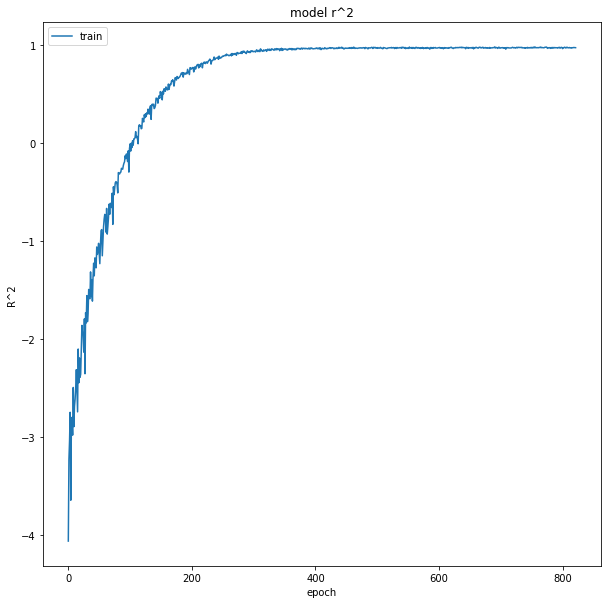

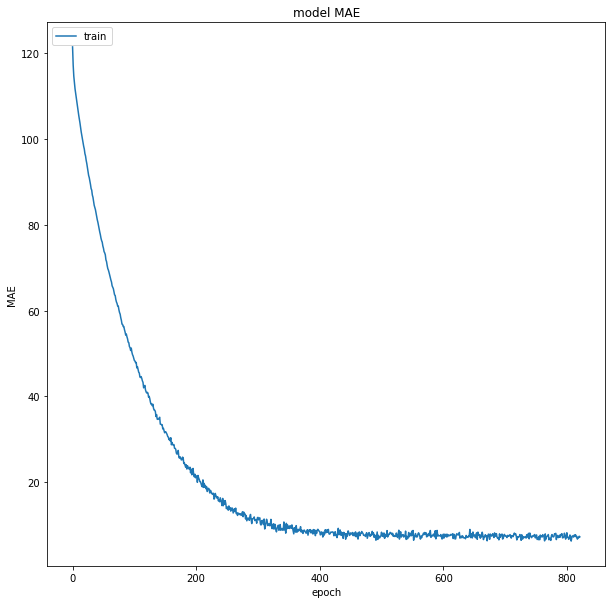

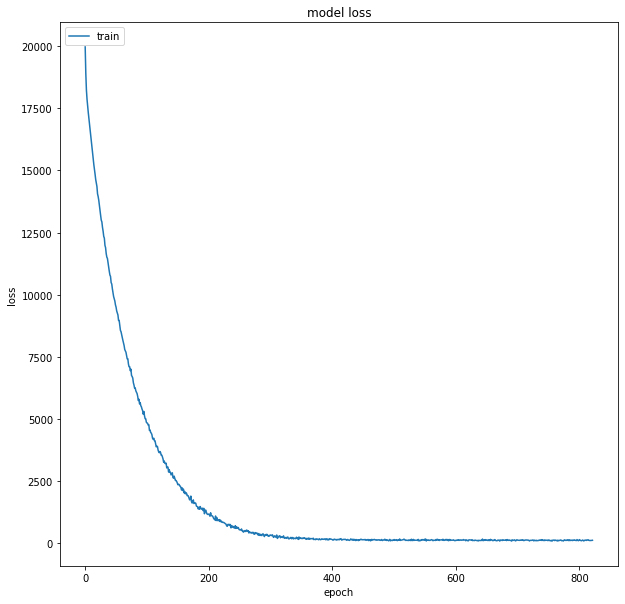

2/2 [==============================] - 1s 7ms/step


In [55]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
#plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for Mae
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
#plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

# training metrics
#scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=24)
#print('\nMAE: {}'.format(scores[1]))
#print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

In [57]:
# pick the feature columns 

sequence_cols=test_df.columns[1:]

# generator for the sequences
#seq_gen=(list(gen_sequence(train_df[train_df.index==id], sequence_length, sequence_cols))  for id in train_df.index)
seq_gen = list(list(gen_sequence(test_df, sequence_length, sequence_cols)))
           

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    
seq_array_test_last=np.reshape(seq_array, (len(seq_gen),sequence_length,len(sequence_cols)))
print(seq_array_test_last.shape)
# generate labels
label_gen = [gen_labels(test_df, sequence_length, ['rul'])]
label_array_test_last = np.concatenate(label_gen).astype(np.float32)
print(label_array_test_last.shape)

(395, 5, 37)
(395, 1)


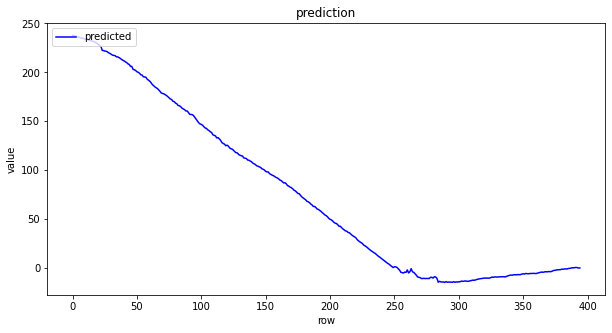

In [59]:


# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    #scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    #print('\nMAE: {}'.format(scores_test[1]))
    #print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="blue")
    #plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")